In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os

dataset_path = "/content/drive/MyDrive/Hack YADRO"

elevation = np.load(os.path.join(dataset_path, "elevation.npy"))
temperature = np.load(os.path.join(dataset_path, "temperature.npy"))
pressure = np.load(os.path.join(dataset_path, "pressure.npy"))
humidity = np.load(os.path.join(dataset_path, "humidity.npy"))
wind_speed = np.load(os.path.join(dataset_path, "wind_speed.npy"))
wind_dir = np.load(os.path.join(dataset_path, "wind_dir.npy"))
cloud_cover = np.load(os.path.join(dataset_path, "cloud_cover.npy"))

data = {'temperature' : temperature,
        'pressure' : pressure,
        'humidity' : humidity,
        'wind_speed' : wind_speed,
        'wind_dir' : wind_dir,
        'cloud_cover' : cloud_cover}

In [4]:
np.unique(data["cloud_cover"])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  94.,  97., 100.], dtype=float32)

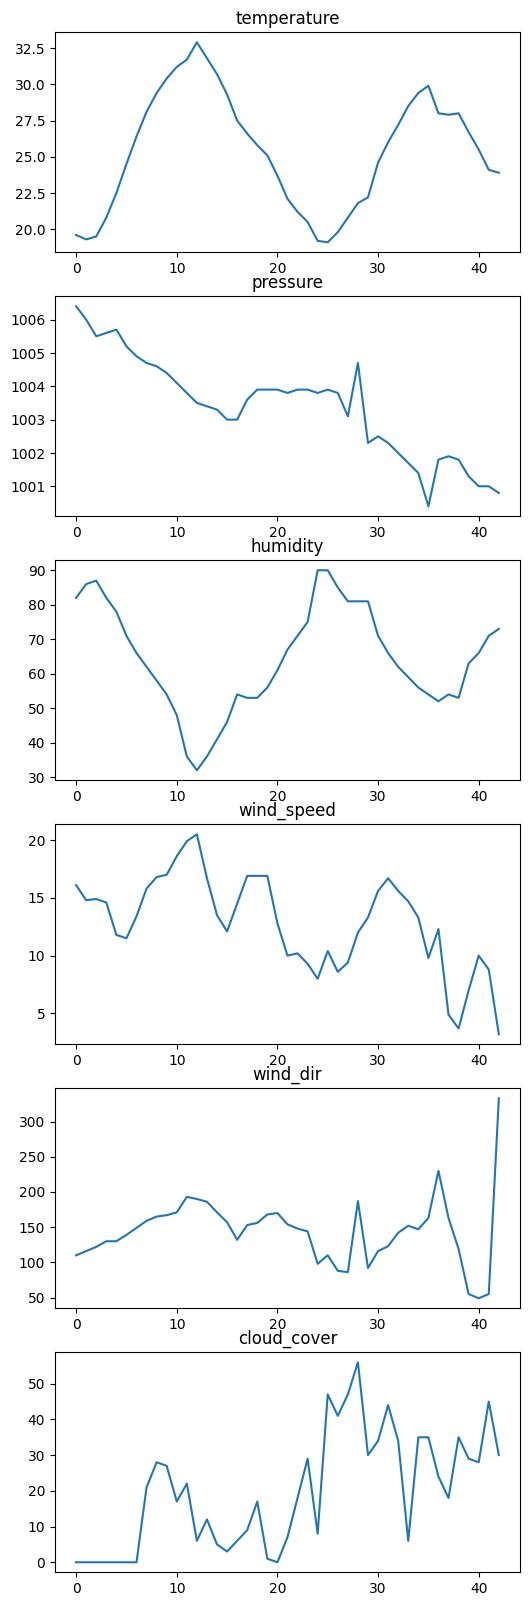

In [145]:
fig, axs = plt.subplots(6, 1, figsize=(6, 20))

for i, feature in enumerate(data.keys()):
  axs[i].plot(data[feature][:, 11, 12])
  axs[i].set_title(feature)

In [146]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.graphics.tsaplots import plot_predict

feature = 'cloud_cover'

example = data[feature][:, 0, 0]

model = ARIMA(example, order=(2, 1, 0))

fitted = model.fit()

forecast = fitted.forecast(5)

params = fitted.params

preds = fitted.predict()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

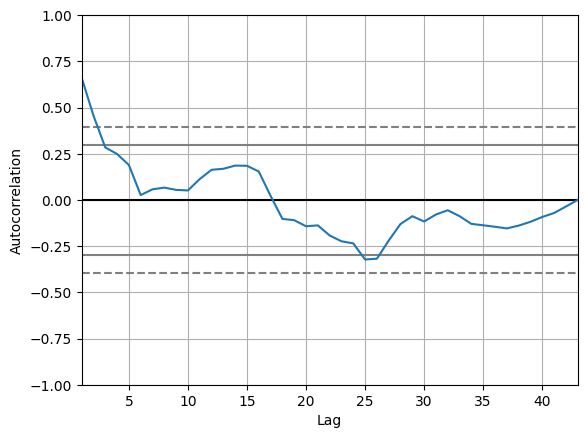

In [143]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(pd.Series(example))

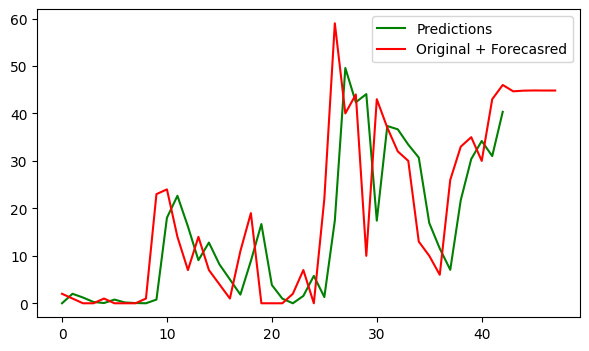

In [147]:
plt.figure(figsize=(7, 4))

plt.plot(preds, label="Predictions", color='green')

plt.plot(np.hstack((example, forecast)), label="Original + Forecasred", color="red")

plt.legend()

In [153]:
#@title Improving features separately

forecast = np.zeros(shape=(5, 30, 30))

for i in range(30):
  for j in range(30):
    model = ARIMA(data[feature][:, i, j], order=(3, 1, 0))
    fitted = model.fit()
    preds = fitted.forecast(5)
    forecast[:, i, j] = preds

flattened_forecast = forecast.flatten()

In [117]:
#@title Win Dir !!

def sincos2deg(sines, cosines):
  rads = np.arctan2(sines, cosines)
  rads = np.array([x + 2 * np.pi if x < 0 else x for x in rads])
  degs = rads * 180 / np.pi
  return degs

forecast = np.zeros(shape=(5, 30, 30))

for i in range(30):
  for j in range(30):
    sines = np.sin(np.deg2rad(data["wind_dir"][:, i, j]))
    cosines = np.cos(np.deg2rad(data["wind_dir"][:, i, j]))

    model_sines = AutoReg(sines, 2).fit()
    model_cosines = AutoReg(cosines, 2).fit()

    preds_sines = model_sines.forecast(5)
    preds_cosines = model_cosines.forecast(5)

    preds = sincos2deg(preds_sines, preds_cosines)

    forecast[:, i, j] = preds

flattened_forecast = forecast.flatten()

In [154]:
features = ["temperature", "pressure", "humidity", "wind_speed", "wind_dir", "cloud_cover"]

solution = pd.read_csv(os.path.join(dataset_path, "solution.csv"), usecols=features)
solution

,temperature,pressure,humidity,wind_speed,wind_dir,cloud_cover
0,22.208396,1001.329226,82.800922,7.412287,11.167782,40.360208
1,22.308396,1001.329226,82.800922,7.412287,11.167782,40.360208
2,22.308396,1001.329226,82.800922,7.412287,11.167782,40.360208
3,21.518518,1001.296160,82.825589,7.673061,11.167782,49.051858
4,21.398058,1001.296160,82.893317,7.673061,11.167782,49.051858
...,...,...,...,...,...,...
4495,20.939478,999.555059,75.255264,9.617468,9.194790,21.887917
4496,21.384644,999.376962,72.631496,7.476896,9.194790,24.135911
4497,21.384644,999.376962,72.631496,7.476896,9.194790,24.135911
4498,21.284643,999.376962,72.631496,7.476896,9.194790,24.135911


In [155]:
solution[feature] = flattened_forecast
solution

,temperature,pressure,humidity,wind_speed,wind_dir,cloud_cover
0,22.208396,1001.329226,82.800922,7.412287,11.167782,45.143049
1,22.308396,1001.329226,82.800922,7.412287,11.167782,45.143049
2,22.308396,1001.329226,82.800922,7.412287,11.167782,45.143049
3,21.518518,1001.296160,82.825589,7.673061,11.167782,53.000686
4,21.398058,1001.296160,82.893317,7.673061,11.167782,53.000686
...,...,...,...,...,...,...
4495,20.939478,999.555059,75.255264,9.617468,9.194790,28.524755
4496,21.384644,999.376962,72.631496,7.476896,9.194790,31.502566
4497,21.384644,999.376962,72.631496,7.476896,9.194790,31.502566
4498,21.284643,999.376962,72.631496,7.476896,9.194790,31.502566


In [156]:
solution.to_csv(os.path.join(dataset_path, "solution_curr.csv"), index_label="ID")

In [132]:
solution.to_csv(os.path.join(dataset_path, "solution.csv"), index_label="ID")

In [ ]:
forecast = {'temperature' : np.zeros(shape=(5, 30, 30)),
            'pressure' : np.zeros(shape=(5, 30, 30)),
            'humidity' : np.zeros(shape=(5, 30, 30)),
            'wind_speed' : np.zeros(shape=(5, 30, 30)),
            'wind_dir' : np.zeros(shape=(5, 30, 30)),
            'cloud_cover' : np.zeros(shape=(5, 30, 30))}

feature = 'temperature'
for feature in data.keys():
  for i in range(30):
    for j in range(30):
      model = AutoReg(data[feature][:, i, j], 5)
      fitted = model.fit()
      preds = fitted.forecast(5)
      forecast[feature][:, i, j] = preds

In [ ]:
flattened_forecast = dict()

for feature in forecast.keys():
  flattened_forecast[feature] = forecast[feature].flatten()

solution = pd.DataFrame(flattened_forecast)
solution.to_csv(os.path.join(dataset_path, "solution.csv"), index_label="ID")

In [50]:
#@title Mean
feature = "wind_dir"
forecast = np.zeros(shape=(5, 30, 30))

for i in range(30):
  for j in range(30):
    mean = data[feature][:, i, j].mean()
    preds = np.full(5, mean)
    forecast[:, i, j] = preds

flattened_forecast = forecast.flatten()

In [ ]:
#@title flatten
elevation = np.expand_dims(elevation, axis=0)
elevation = np.repeat(elevation, 43, axis=0)
elevation = np.reshape(elevation, elevation.shape[0]*elevation.shape[1]*elevation.shape[2])

temperature = temperature.flatten()

pressure = pressure.flatten()

humidity = humidity.flatten()

wind_speed = wind_speed.flatten()

wind_dir = wind_dir.flatten()

cloud_cover = cloud_cover.flatten()

data = {'elevation' : elevation,
        'temperature' : temperature,
        'pressure' : pressure,
        'humidity' : humidity,
        'wind_speed' : wind_speed,
        'wind_dir' : wind_dir,
        'cloud_cover' : cloud_cover}

df = pd.DataFrame(data)
df